# 实验参数设置

In [22]:
from FederatedLearning.learner import CNNModel

clients_num = 10 # 客户端总数
rotation_cycle = 5 # 角色轮换间隔轮数
max_round = 20 # 联邦学习轮数
learning_rate = 0.01
model_class = CNNModel # 选用CNN模型

## 数据切分

In [23]:
import data_split
# 使用data_split模块中的函数获取PyTorch数据集
train_dataset = data_split.get_mnist_pytorch_dataset(train=True)
test_dataset = data_split.get_mnist_pytorch_dataset(train=False)
# test
# 使用正确的数据集对象创建数据加载器
client_dataloaders = data_split.create_client_dataloaders(train_dataset, clients_num // 2, 64, num_workers=clients_num) * 2
client_test_loader = data_split.create_client_dataloaders(test_dataset, clients_num // 2, 64) * 2

2025-10-20 17:11:45,499 - DGS_BCFL - INFO - 
切分5份数据集...
2025-10-20 17:11:45,557 - DGS_BCFL - INFO -  1 数据准备完成，样本数: 12000
2025-10-20 17:11:46,009 - DGS_BCFL - INFO -  2 数据准备完成，样本数: 12000
2025-10-20 17:11:46,231 - DGS_BCFL - INFO -  3 数据准备完成，样本数: 12000
2025-10-20 17:11:47,007 - DGS_BCFL - INFO -  4 数据准备完成，样本数: 12000
2025-10-20 17:11:47,348 - DGS_BCFL - INFO -  5 数据准备完成，样本数: 12000
2025-10-20 17:11:47,375 - DGS_BCFL - INFO - 
切分5份数据集...
2025-10-20 17:11:47,412 - DGS_BCFL - INFO -  1 数据准备完成，样本数: 2000
2025-10-20 17:11:47,434 - DGS_BCFL - INFO -  2 数据准备完成，样本数: 2000
2025-10-20 17:11:48,208 - DGS_BCFL - INFO -  3 数据准备完成，样本数: 2000
2025-10-20 17:11:48,255 - DGS_BCFL - INFO -  4 数据准备完成，样本数: 2000
2025-10-20 17:11:48,323 - DGS_BCFL - INFO -  5 数据准备完成，样本数: 2000


## 开始训练

In [21]:
from owner import Owner
from client import Client

# 初始化管理者，并获得初始化字典
owner = Owner(rotation_cycle=1, model_class=model_class)
main_dict = owner.get_main_dict()

# 初始化客户端以及身份
clients = [owner]
for i in range(clients_num):
    client_name = f"client_{i + 1}"
    client = Client(epochs=2, client_name=client_name, data_loader=client_dataloaders[i],
                    test_loader=client_test_loader[i], ModelClass=model_class, main_dict=main_dict, learning_rate=learning_rate)
    owner.join(client_name)
    clients.append(client)

import threading

for _ in range(max_round):
    t = [threading.Thread(target=client.run) for client in clients]
    _ = [i.start() for i in t]
    _ = [i.join() for i in t]


# 保存实验过程和结果
import pickle
with open("main_dict.pkl", "wb") as f:
    pickle.dump(main_dict, f)

2025-10-20 16:50:26,879 - DGS_BCFL - INFO - Owner开始初始化 角色
2025-10-20 16:50:26,880 - DGS_BCFL - INFO - [client_1]  round 1 等待角色分配...
2025-10-20 16:50:26,881 - DGS_BCFL - INFO - [client_2]  round 1 等待角色分配...
2025-10-20 16:50:26,881 - DGS_BCFL - INFO - 初始化完成 {'role': [{'client_1': 'aggregator', 'client_2': 'validator', 'client_3': 'validator', 'client_4': 'validator', 'client_5': 'learner', 'client_6': 'learner', 'client_7': 'learner', 'client_8': 'learner', 'client_9': 'learner', 'client_10': 'learner'}], 'global_model': ['./global_model/init_global_model'], 'client_gradients': [], 'votes': [], 'contribution': {'client_1': 0, 'client_2': 0, 'client_3': 0, 'client_4': 0, 'client_5': 0, 'client_6': 0, 'client_7': 0, 'client_8': 0, 'client_9': 0, 'client_10': 0}, 'global_accuracy_history': [], 'contribution_history': []}
2025-10-20 16:50:26,883 - DGS_BCFL - INFO - [client_3] 当前轮次角色: validator
2025-10-20 16:50:26,884 - DGS_BCFL - INFO - [client_4] 当前轮次角色: validator
2025-10-20 16:50:26,885 - 

KeyboardInterrupt: 

    data = self._data_queue.get(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zyserver/miniconda3/envs/bcfl/lib/python3.12/queue.py", line 179, in get
    raise Empty
_queue.Empty

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/zyserver/miniconda3/envs/bcfl/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/zyserver/miniconda3/envs/bcfl/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "/home/zyserver/miniconda3/envs/bcfl/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/pycharm_project_838/DGS_BCFL/src/client.py", line 134, in run
    self._run_as_learner()
  File "/tmp/pycharm_project_838/DGS_BCFL/src/client.py", line 223, in _run_as_learner
    train_results = learner.train()
                    ^^^^^^^^^^^^^^^
  File 

## 计算结果可视化

[10.5, 92.25, 92.55, 96.1, 96.75, 97.5, 97.8, 97.85, 98.15, 97.85, 98.15]


/tmp/ipykernel_3019641/1319006179.py:52: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3019641/1319006179.py:52: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3019641/1319006179.py:52: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3019641/1319006179.py:52: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3019641/1319006179.py:52: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3019641/1319006179.py:52: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3019641/1319006179.py:52: UserWarning: Glyph 24230 (\N{CJK UN

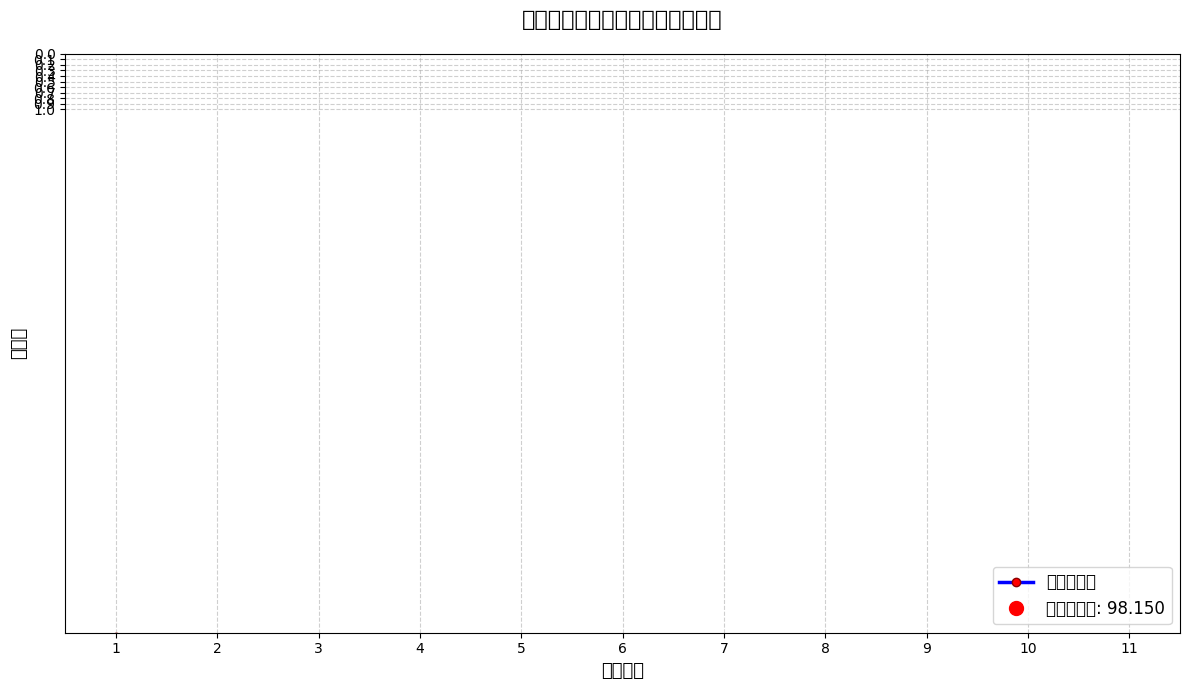

In [19]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
# 读取实验结果
main_dict = pickle.load(open("main_dict.pkl", "rb"))
# 进行可视化
global_accuracy_history = main_dict["global_accuracy_history"]
print(global_accuracy_history)

# 假设accuracies是你的精度列表
# accuracies = [0.60, 0.70, 0.75, 0.80, 0.82, 0.85, 0.87, 0.89, 0.90, 0.91]  # 示例数据

# 创建图形
plt.figure(figsize=(12, 7))

# 绘制主要曲线
epochs = list(range(1, len(global_accuracy_history) + 1))
plt.plot(epochs, global_accuracy_history, 'b-', linewidth=2.5, marker='o', markersize=6, 
         markerfacecolor='red', markeredgecolor='darkred', markeredgewidth=1, 
         label='模型准确度')

# 标记最高准确度点
max_acc = max(global_accuracy_history)
max_epoch = global_accuracy_history.index(max_acc) + 1
plt.plot(max_epoch, max_acc, 'ro', markersize=10, label=f'最高准确度: {max_acc:.3f}')

# 添加标注
plt.annotate(f'最高: {max_acc:.3f}', 
             xy=(max_epoch, max_acc), 
             xytext=(max_epoch+0.5, max_acc-0.05),
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             fontsize=10, color='red')

# 自定义图表
plt.title('联邦学习模型训练准确度变化曲线', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('训练轮次', fontsize=13)
plt.ylabel('准确度', fontsize=13)

# 设置坐标轴
plt.xlim(0.5, len(global_accuracy_history) + 0.5)
plt.ylim(max(0, min(global_accuracy_history) - 0.08), min(1.0, max(global_accuracy_history) + 0.05))

# 添加网格和样式调整
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='lower right')

# 设置刻度
plt.xticks(epochs)
plt.yticks(np.arange(0, 1.1, 0.1))

# 美化样式
plt.tight_layout()

# 显示图表
plt.show()

# 保存图表（可选）
# plt.savefig('federated_learning_accuracy_detailed.png', dpi=300, bbox_inches='tight')

